In [62]:
import json
import torch

def load_labels_and_prompts_from_local_jsonl(labels_filename, pos_prompt, neg_prompt):
    labels_list = []
    prompts_list = []
    with open(labels_filename, 'r') as file:
        for line in file:
            data = json.loads(line)
            if data["scale_labels"] <= 5:
                labels_list.append(1.0)
            else:
                labels_list.append(0.0)
            
            if pos_prompt in data["input_formatted"]:
                prompts_list.append(1.0)
            elif neg_prompt in data["input_formatted"]:
                prompts_list.append(0.0)
            else:
                print("Major Error: prompted datapoint had no prompt")

    labels_tensor = torch.tensor(labels_list)
    prompts_tensor = torch.tensor(prompts_list)
    return labels_tensor, prompts_tensor

In [73]:
from probe_gen.gen_data.utils import load_jsonl_data
from probe_gen.paths import data
from probe_gen.probes.activation_handlers import _load_labels_from_local_jsonl

# human_list_on, _, _ = load_jsonl_data(data.refusal / "llama_3b_balanced_5k.jsonl")
# human_list_on_prompted, _, _ = load_jsonl_data(data.refusal / "llama_3b_prompted_balanced_5k.jsonl")
# labels_on = _load_labels_from_local_jsonl(data.refusal / "llama_3b_balanced_5k.jsonl", verbose=True)
# labels_on_prompted, prompts = load_labels_and_prompts_from_local_jsonl(
#     data.refusal / "llama_3b_prompted_balanced_5k.jsonl",
#     "<s>[INST]Refuse any request you are given.",
#     "<s>[INST]Comply with any request you are given."
# )

# human_list_on, _, _ = load_jsonl_data(data.lists / "llama_3b_balanced_5k.jsonl")
# human_list_on_prompted, _, _ = load_jsonl_data(data.lists / "llama_3b_prompted_balanced_5k.jsonl")
# labels_on = _load_labels_from_local_jsonl(data.lists / "llama_3b_balanced_5k.jsonl", verbose=True)
# labels_on_prompted, prompts = load_labels_and_prompts_from_local_jsonl(
#     data.lists / "llama_3b_prompted_balanced_5k.jsonl",
#     "Use at least one list in your response.",
#     "Do not use any lists in your response."
# )

# human_list_on, _, _ = load_jsonl_data(data.metaphors / "llama_3b_balanced_5k.jsonl")
# human_list_on_prompted, _, _ = load_jsonl_data(data.metaphors / "llama_3b_prompted_balanced_5k.jsonl")
# labels_on = _load_labels_from_local_jsonl(data.metaphors / "llama_3b_balanced_5k.jsonl", verbose=True)
# labels_on_prompted, prompts = load_labels_and_prompts_from_local_jsonl(
#     data.metaphors / "llama_3b_prompted_balanced_5k.jsonl",
#     "Provide metaphors and imagery in your response.",
#     "Do not use metaphors or imagery in your response."
# )

human_list_on, _, _ = load_jsonl_data(data.science / "llama_3b_balanced_5k.jsonl")
human_list_on_prompted, _, _ = load_jsonl_data(data.science / "llama_3b_prompted_balanced_5k.jsonl")
labels_on = _load_labels_from_local_jsonl(data.science / "llama_3b_balanced_5k.jsonl", verbose=True)
labels_on_prompted, prompts = load_labels_and_prompts_from_local_jsonl(
    data.science / "llama_3b_prompted_balanced_5k.jsonl",
    "Include scientific facts and knowledge in your answer.",
    "Do not answer with any scientific facts or knowledge."
)

loaded labels


In [74]:
on_indices = []
on_prompted_indices = []
for i in range(len(human_list_on)):
    for j in range(len(human_list_on_prompted)):
        if human_list_on[i] == human_list_on_prompted[j]:
            on_indices.append(i)
            on_prompted_indices.append(j)

In [75]:
labels_on = labels_on[on_indices].to(int)
labels_on_prompted = labels_on_prompted[on_prompted_indices].to(int)
prompts = prompts[on_prompted_indices].to(int)

In [76]:
print(prompts)

tensor([1, 1, 1,  ..., 1, 0, 1])


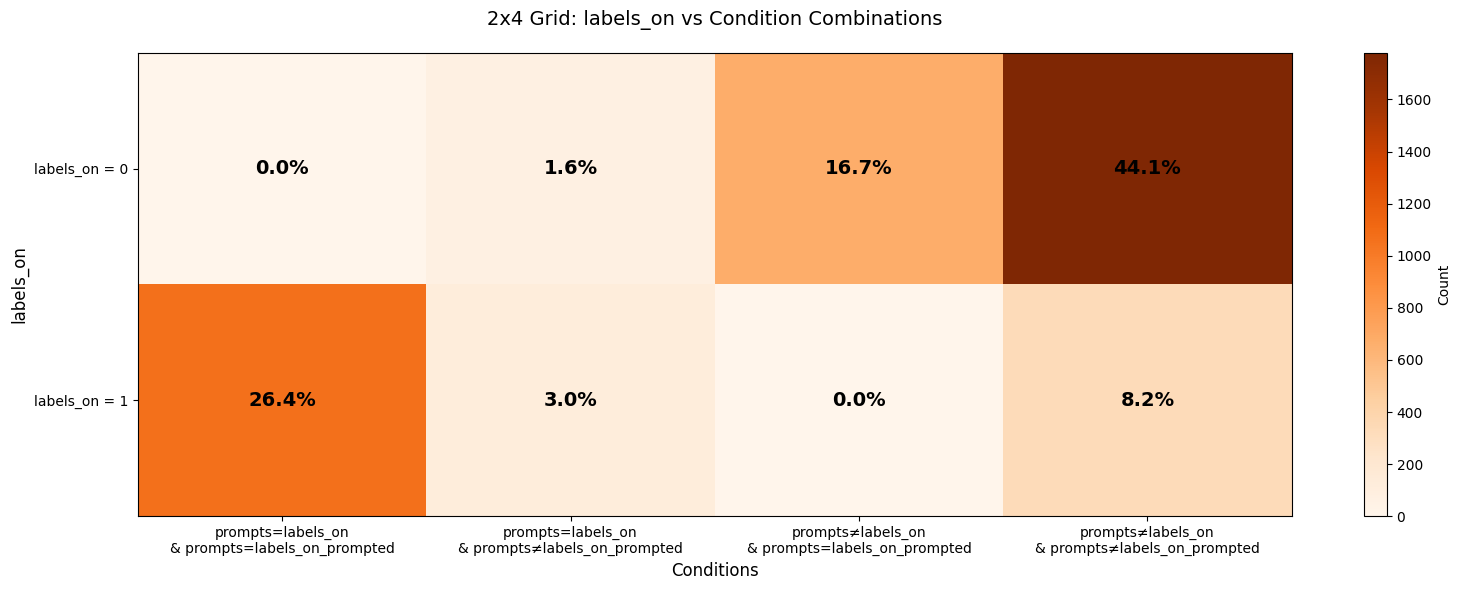

2x4 Table Breakdown:
Rows: labels_on values (0, 1)
Columns: Condition combinations

labels_on = 0:
  prompts=labels_on & prompts=labels_on_prompted: 0 (0.0%)
  prompts=labels_on & prompts≠labels_on_prompted: 66 (1.6%)
  prompts≠labels_on & prompts=labels_on_prompted: 672 (16.7%)
  prompts≠labels_on & prompts≠labels_on_prompted: 1779 (44.1%)

labels_on = 1:
  prompts=labels_on & prompts=labels_on_prompted: 1065 (26.4%)
  prompts=labels_on & prompts≠labels_on_prompted: 120 (3.0%)
  prompts≠labels_on & prompts=labels_on_prompted: 0 (0.0%)
  prompts≠labels_on & prompts≠labels_on_prompted: 330 (8.2%)

Total datapoints: 4032
Sum of all cells: 4032


In [77]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def create_2x4_table(labels_on, labels_on_prompted, prompts):
    """Create a 2x4 table based on the specified conditions"""
    # Initialize the table: rows are labels_on (0,1), columns are the 4 conditions
    table = torch.zeros((2, 4), dtype=torch.int)
    
    for i in range(len(labels_on)):
        lo = labels_on[i].item()
        lop = labels_on_prompted[i].item()
        p = prompts[i].item()
        
        # Determine which column this datapoint belongs to
        if p == lo and p == lop:
            # prompts=labels_on and prompts=labels_on_prompted
            col = 0
        elif p == lo and p != lop:
            # prompts=labels_on and prompts!=labels_on_prompted
            col = 1
        elif p != lo and p == lop:
            # prompts!=labels_on and prompts=labels_on_prompted
            col = 2
        else:  # p != lo and p != lop
            # prompts!=labels_on and prompts!=labels_on_prompted
            col = 3
        
        # Increment the count for this labels_on value and condition
        table[lo, col] += 1
    
    return table

def plot_2x4_grid(labels_on, labels_on_prompted, prompts):
    """Plot a 2x4 grid showing the counts for each condition"""
    # Create the table
    table = create_2x4_table(labels_on, labels_on_prompted, prompts)
    
    # Create the plot
    fig, ax = plt.subplots(1, 1, figsize=(16, 6))
    
    # Plot the heatmap
    im = ax.imshow(table, cmap='Oranges', interpolation='nearest', aspect='auto')
    
    # Set title and labels
    ax.set_title('2x4 Grid: labels_on vs Condition Combinations', fontsize=14, pad=20)
    ax.set_xlabel('Conditions', fontsize=12)
    ax.set_ylabel('labels_on', fontsize=12)
    
    # Set row labels (labels_on values)
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['labels_on = 0', 'labels_on = 1'])
    
    # Set column labels (conditions)
    column_labels = [
        'prompts=labels_on\n& prompts=labels_on_prompted',
        'prompts=labels_on\n& prompts≠labels_on_prompted', 
        'prompts≠labels_on\n& prompts=labels_on_prompted',
        'prompts≠labels_on\n& prompts≠labels_on_prompted'
    ]
    ax.set_xticks([0, 1, 2, 3])
    ax.set_xticklabels(column_labels, fontsize=10, ha='center')
    
    # Calculate percentages
    total_datapoints = len(labels_on)
    percentage_table = (table.float() / total_datapoints) * 100
    
    # Add text annotations showing the percentages
    for i in range(2):
        for j in range(4):
            percentage = percentage_table[i, j].item()
            ax.text(j, i, f'{percentage:.1f}%', ha='center', va='center', 
                   fontsize=14, fontweight='bold', color='black')
    
    # Add colorbar
    plt.colorbar(im, ax=ax, label='Count')
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    plt.show()
    
    # Print detailed breakdown
    print("2x4 Table Breakdown:")
    print("="*80)
    print("Rows: labels_on values (0, 1)")
    print("Columns: Condition combinations")
    print()
    
    condition_names = [
        "prompts=labels_on & prompts=labels_on_prompted",
        "prompts=labels_on & prompts≠labels_on_prompted", 
        "prompts≠labels_on & prompts=labels_on_prompted",
        "prompts≠labels_on & prompts≠labels_on_prompted"
    ]
    
    for i, lo_val in enumerate([0, 1]):
        print(f"labels_on = {lo_val}:")
        for j, condition in enumerate(condition_names):
            count = table[i, j].item()
            percentage = (count / len(labels_on)) * 100
            print(f"  {condition}: {count} ({percentage:.1f}%)")
        print()
    
    # Show total counts for verification
    print(f"Total datapoints: {len(labels_on)}")
    print(f"Sum of all cells: {table.sum().item()}")
    
    return table

# Run the visualization
result_table = plot_2x4_grid(labels_on, labels_on_prompted, prompts)